# GEDI
#### GEDI04_A - Level 4A Footprint Above Ground Biomass
#### [ORNL DAAC](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2056)
#### [ORNL GEDI Tutorial](https://github.com/ornldaac/gedi_tutorials)

In [2]:
import datetime as dt

bbox_ll = [29.270558, -1.648015, 29.705426, -1.311937] # larger Virunga, lat/lng
gedi_start_date = dt.datetime(2021, 9, 1) 
gedi_end_date = dt.datetime(2022, 6, 1)

In [2]:
import datetime as dt
import geopandas as gpd
import pandas as pd
import rasterio
import requests
from shapely.geometry import MultiPolygon, Polygon, box, shape


# DOI: Digital Object Identifier
doi = '10.3334/ORNLDAAC/2056' # GEDI L4A DOI 

# CMR: Common Metadata Repository
cmr_url = 'https://cmr.earthdata.nasa.gov/search' 
search_url = f'{cmr_url}/collections.json?doi={doi}'

# Unique NASA-given concept ID for the GEDI 4A dataset, used to retrieve relevant files (or granules) for GEDI L4A
concept_id = requests.get(search_url).json()['feed']['entry'][0]['id']
print(concept_id)

C2237824918-ORNL_CLOUD


In [275]:
date_format = '%Y-%m-%dT%H:%M:%SZ'
date_string = start_date.strftime(date_format) + ',' + end_date.strftime(date_format)

bbox_string = ','.join(map(str, bbox_ll)) # lng1,lat1,lng2,lat2

granules_list = []
page_size, page_num = 2000, 1

while True:    
    cmr_params = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": date_string,
        "bounding_box[]": bbox_string
    }
    
    granules_url = f'{cmr_url}/granules.json'
    granules_res = requests.get(granules_url, params=cmr_params)
    granules = granules_res.json()['feed']['entry']
        
    if granules:
        for g in granules:

            granule_url = ''
            granule_polygon = ''            
            granule_size = float(g['granule_size'])
            
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i = iter(poly[0].split(" "))
                    latlng = list(map(" ".join, zip(i, i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in latlng]))
                    
                granule_polygon = MultiPolygon(multipolygons)
            
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
                    
            granules_list.append([granule_url, granule_size, granule_polygon])
               
        page_num += 1
        
    else: 
        break

In [276]:
granules_list.append(['bound', 0, box(bbox_ll[0], bbox_ll[1], bbox_ll[2], bbox_ll[3])]) # for plotting
gedi_df = pd.DataFrame(granules_list, columns=["granule_url", "granule_size", "granule_polygon"])
gedi_df = gedi_df[gedi_df['granule_polygon'] != '']

print("Total granules found:", len(gedi_df.index)-1)
print("Total file size (MB): %0.2f" % gedi_df['granule_size'].sum())

Total granules found: 8
Total file size (MB): 1399.12


(-2.554519, -0.3758950000000001)

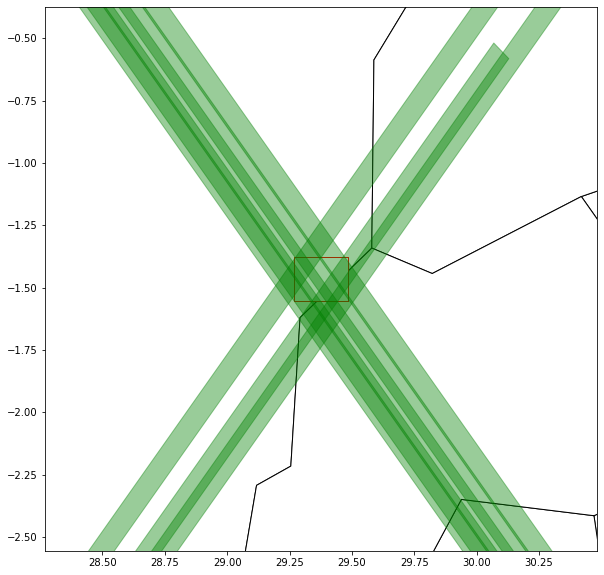

In [277]:
gdf = gpd.GeoDataFrame(gedi_df, geometry=gedi_df.granule_polygon)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize=(10, 10))

# last row contains the bounding box (Red)
ax = gdf[-1:].plot(ax=base, color='white', edgecolor='red', alpha=1.0)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.4)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

In [279]:
gedi_granules = gedi_df[:-1].drop_duplicates(subset=['granule_url'])
gedi_granules.to_csv('/shared_space/G1/gedi/granules.txt', columns = ['granule_url'], index=False, header = False)

## Setup EarthData Authorization
#### 1. Go to https://urs.earthdata.nasa.gov/ and approve all the ORNL applications (not sure which one matters)
#### 2. Setup credentials on container
- #### touch ~/.netrc
- #### echo "machine urs.earthdata.nasa.gov login uid_goes_here password password_goes_here" > ~/.netrc
- #### chmod 0600 ~/.netrc  

In [280]:
%%bash

wget -P /shared_space/G1/gedi -nv -q --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -nc -i /shared_space/G1/gedi/granules.txt

In [307]:
import glob
import os

data_dirs = ["/shared_space/G1/gedi", "/shared_space/G1/s2"]
for ddir in data_dirs:
    if not os.path.exists(ddir):
        os.mkdir(ddir)

# removes query string from downloaded H5 files
h5_files = glob.glob('/shared_space/G1/gedi/*.h5[?]*')
for file in h5_files:
    os.rename(file, file.split('.h5')[0] + '.h5')

# Sentinel-2

#### [PySTAC](https://pystac-client.readthedocs.io/en/stable/quickstart.html)

#### The code below is just for Sentinel-2, not Harmonized Landsat Sentinel-2
#### I couldn't find a convenient way to access HLS data - Casey

In [3]:
# If you want to change the Sentinel imagery dates, do that below
# I'm not sure which Sentinel images we should use - Casey
s2_start_date = dt.datetime(2021, 1, 1) # start_date
s2_end_date = dt.datetime(2022, 12, 12) # end_date
assert s2_end_date > s2_start_date

# CONSTANTS

In [21]:
data_dir = 'data' # "/shared_space/G1/s2/" # ./data/s2/
s2_dir = f'{data_dir}/s2'
bands = ['SCL', 'B02', 'B03', 'B04', 'B08'] # make sure SCL first
nodata_uint16 = 65535
nodata_byte = 255

In [27]:
from pystac import ItemCollection
from pystac_client import Client

stac_date_format = '%Y-%m-%dT%H:%M:%SZ'
stac_date_string = s2_start_date.strftime(stac_date_format) + '/' + s2_end_date.strftime(stac_date_format)

# Open a catalog
client = Client.open("https://earth-search.aws.element84.com/v0")

# Get results for a collection in the catalog
search = client.search(
    bbox=bbox_ll,
    collections=['sentinel-s2-l2a-cogs'], 
    datetime=stac_date_string,
    sortby='-properties.datetime',
    query={
        "eo:cloud_cover":{
            "lt": "8"
        },
    },
    
)

print(f"{search.matched()} items found")

# limit number of images per Sentinel zone
limit = 8
items, items_count = [], {}
for item in list(search.items()):
    square = item.properties['sentinel:grid_square']
    count = items_count.get(square, 0)
    if count < limit:
        items.append(item)
        items_count[square] = count + 1

print(f'{len(items)} filtered items')
        
collection = ItemCollection(items=items)
collection.save_object('./s2_collection.json')

28 items found
16 filtered items


### Visualize the coverage of the S2 scenes

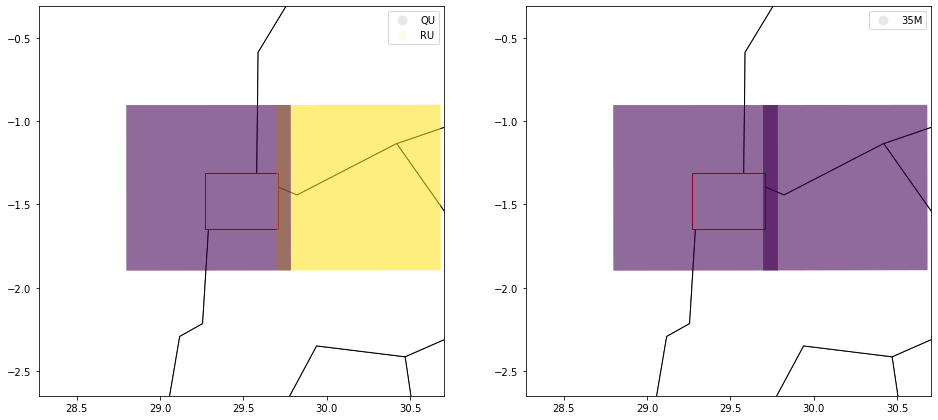

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import box, shape


#items = list(search.items_as_dicts())
s2_list = [[i.id, shape(i.geometry), i.properties['sentinel:grid_square'], str(i.properties['sentinel:utm_zone']) + i.properties['sentinel:latitude_band']] for i in items]
s2_list.append(['bounds', box(*bbox_ll), ''])
s2_df = pd.DataFrame(s2_list, columns=["id", "polygon", "grid_square", "utm_zone"])

s2_gdf = gpd.GeoDataFrame(s2_df, geometry=s2_df.polygon)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# tiles colored by grid_square ID
base1 = world.plot(ax=ax1, color='white', edgecolor='black', figsize=(10, 10)) # AxesSubplot
s2_gdf[-1:].plot(ax=base1, color='white', edgecolor='red', alpha=1.0)
s2_gdf[:-1].plot(ax=base1, column='grid_square', cmap = "viridis", alpha=0.1, legend=True)

# tiles colored date
base2 = world.plot(ax=ax2, color='white', edgecolor='black', figsize=(10, 10))
s2_gdf[-1:].plot(ax=base2, color='white', edgecolor='red', alpha=1.0)
s2_gdf[:-1].plot(ax=base2, column='utm_zone', cmap = "viridis", alpha=0.1, legend=True)

minx, miny, maxx, maxy = s2_gdf[-1:].geometry.total_bounds
ax1.set_xlim(minx-1, maxx+1)
ax1.set_ylim(miny-1, maxy+1)

ax2.set_xlim(minx-1, maxx+1)
ax2.set_ylim(miny-1, maxy+1)

plt.show()

In [30]:
from functools import partial
import pyproj
from shapely.geometry import box, Point, Polygon, shape
from shapely.ops import transform as shapely_transform
    

def reproject_shape(polygon, init_proj, target_proj):
    """
    EPSG: 4326, World Geodetic System 1984, degrees
    EPSG: 3857, Pseudo-Mercator / Google Maps, meters
    """
    reproject = partial(pyproj.transform, pyproj.Proj(init=init_proj), pyproj.Proj(init=target_proj))
    
    return shapely_transform(reproject, polygon)


def get_bbox_coverage(item, bbox):
    
    item_poly_ll = shape(item["geometry"])
    bbox_poly_ll = box(*bbox_ll)
    
    # reproject to equal area so we get meters result
    item_poly_ea = reproject_shape(item_poly_ll, "epsg:4326", "epsg:3857")
    bbox_poly_ea = reproject_shape(bbox_poly_ll, "epsg:4326", "epsg:3857")
    
    intersection_poly_ea = bbox_poly_ea.intersection(item_poly_ea)
    intersection_pct = (intersection_poly_ea.area * 100) / bbox_poly_ea.area

    return intersection_pct


## Download imagery

#### This method uses Rasterio Windows, which uses HTTP Range requests under the hood to download bounding box only

In [32]:
import numpy as np
import os
from osgeo import gdal
import osr
import rasterio
from rasterio.plot import show
from shapely.geometry import box, shape

if not os.path.exists(s2_dir):
    os.makedirs(s2_dir)

bbox_poly_ll = box(*bbox_ll)
bbox_poly_ea = reproject_shape(bbox_poly_ll, "epsg:4326", "epsg:3857")

temp_bounds_ea = bbox_poly_ea.bounds
xmin_ea = temp_bounds_ea[0]
xmax_ea = temp_bounds_ea[2] 
ymin_ea = temp_bounds_ea[1]
ymax_ea = temp_bounds_ea[3] 

temp_width_ea = int(np.rint(np.abs((xmin_ea - xmax_ea)) / 10))
temp_height_ea = int(np.rint(np.abs((ymin_ea - ymax_ea)) / 10))

driver = gdal.GetDriverByName('GTiff')
spatref = osr.SpatialReference()
spatref.ImportFromEPSG(3857)
wkt = spatref.ExportToWkt()

outfn = f'{s2_dir}/temp.tif'
nbands = 1
xres_ea = 10
yres_ea = -10

dtype = gdal.GDT_UInt16

xsize = int(np.rint(np.abs((xmax_ea - xmin_ea)) / xres_ea))
ysize = int(np.rint(np.abs((ymax_ea - ymin_ea) / yres_ea)))

ds = driver.Create(outfn, xsize, ysize, nbands, dtype, options=['COMPRESS=LZW', 'TILED=YES'])
ds.SetProjection(wkt)
ds.SetGeoTransform([xmin_ea, xres_ea, 0, ymax_ea, 0, yres_ea])
ds.GetRasterBand(1).Fill(nodata_uint16)
ds.GetRasterBand(1).SetNoDataValue(nodata_uint16)
ds.FlushCache()
ds = None

In [34]:
%%time

import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal
import rasterio
import rasterio.merge
from rasterio.plot import show
from shapely.geometry import box, shape
import time # TESTING
   
if not os.path.exists(s2_dir):
    os.makedirs(s2_dir)
    
bbox_poly_ll = box(*bbox_ll) # lat/lng
bbox_poly_ea = reproject_shape(bbox_poly_ll, "epsg:4326", "epsg:3857") # equal area

temp_bounds_ea = bbox_poly_ea.bounds
temp_width_ea = int(np.rint(np.abs((temp_bounds_ea[0] - temp_bounds_ea[2])) / 10))
temp_height_ea = int(np.rint(np.abs((temp_bounds_ea[1] - temp_bounds_ea[3])) / 10))
temp_array_ea = np.zeros((temp_height_ea, temp_width_ea))


for item in list(collection):
    print()
    print(item.id)
    print(item.properties["sentinel:grid_square"], "-", str(item.properties['sentinel:utm_zone']) + item.properties["sentinel:latitude_band"])
    
    band_hrefs = [item.assets[band].href for band in bands]
    
    # reproject bounding box into projection of Sentinel scene so we use Window
    item_epsg = f'epsg:{item.properties["proj:epsg"]}'
    bbox_sw_utm = reproject_shape(Point(bbox_ll[0], bbox_ll[1]), init_proj="epsg:4326", target_proj=item_epsg)
    bbox_ne_utm = reproject_shape(Point(bbox_ll[2], bbox_ll[3]), init_proj="epsg:4326", target_proj=item_epsg)
    
    # calculate intersection between Sentinel scene and bounding box so that we can save data properly to tif
    scene_poly_ll = shape(item.geometry) # Polygon of the entire original image
    overlap_poly_ll = bbox_poly_ll.intersection(scene_poly_ll)
    overlap_poly_ea = reproject_shape(overlap_poly_ll, "epsg:4326", "epsg:3857") # equal area, used in gdal.Warp so all data has same projection

    # get overlap in item UTM projection so we can save subset of data to tif
    overlap_bbox_ll = overlap_poly_ll.bounds # lat/lng
    overlap_sw_utm = reproject_shape(Point(overlap_bbox_ll[0], overlap_bbox_ll[1]), init_proj="epsg:4326", target_proj=item_epsg)
    overlap_ne_utm = reproject_shape(Point(overlap_bbox_ll[2], overlap_bbox_ll[3]), init_proj="epsg:4326", target_proj=item_epsg)
        
    if not os.path.exists(f'{s2_dir}/{item.id}'):
        os.mkdir(f'{s2_dir}/{item.id}')
            
    for s3_href in band_hrefs:
        
        band_name = s3_href.split('/')[-1].split('.')[0]
        file_path = f'{s2_dir}/{item.id}/{band_name}.tif'
        
        if os.path.exists(file_path):
            continue
                
        with rasterio.open(s3_href) as s3_src:

            # create window and only read data from the window, rather than entire file
            window = rasterio.windows.from_bounds(bbox_sw_utm.x, bbox_sw_utm.y, bbox_ne_utm.x, bbox_ne_utm.y, s3_src.transform)
            data = s3_src.read(1, window=window)
            height, width = data.shape[0], data.shape[1]
            print(f'\t{band_name}... rows: {height}, cols: {width}')

            # applying the cloud mask here is weird because the SCL is not yet aligned with the other bands

            new_transform = rasterio.transform.from_bounds(overlap_sw_utm.x, overlap_sw_utm.y, overlap_ne_utm.x, overlap_ne_utm.y, width, height)
            kwargs = {
                "mode": "w",
                "driver": "GTiff",
                "height": height,
                "width": width,
                "count": 1,
                "dtype": data.dtype,
                "crs": s3_src.crs,
                "transform": new_transform
            }
            
            if band_name == "SCL":
                kwargs["nodata"] = nodata_byte # 255
            else:
                kwargs["nodata"] = nodata_uint16 # 65535

            # write the data that overlaps with the bbox to file
            with rasterio.open(file_path,  **kwargs) as new_src:
                new_src.write(data, 1)

            # convert the file to equal area proj and 10 meter resolution
            gdal.Warp(file_path, file_path, dstSRS="EPSG:3857", xRes=10, yRes=10, outputBounds=overlap_poly_ea.bounds)

            # merge data with blank raster so that all files have same bounds (facilitates making composite)       
            with rasterio.open(f'{s2_dir}/temp.tif') as temp_src:
                
                with rasterio.open(file_path) as data_src:
                    
                    # if the bounds are the same then just skip merging
                    tbnds, dbnds = temp_src.bounds, data_src.bounds
                    if tbnds.left == dbnds.left and tbnds.bottom == dbnds.bottom and \
                       tbnds.right == dbnds.right and tbnds.top == dbnds.top:
                        continue

                    merged, transform = rasterio.merge.merge([data_src, temp_src], bounds=bbox_poly_ea.bounds)
                    merged = merged[0, :, :]

                    merged_profile = temp_src.profile.copy()
                    if band_name == "SCL":
                        merged_profile["dtype"] = "uint8"
                        merged_profile["nodata"] = nodata_byte

            with rasterio.open(file_path, "w", **merged_profile) as new_src:
                new_src.write(merged, 1)
                           


S2B_35MRU_20221014_0_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02... rows: 3712, cols: 110
	B03... rows: 3712, cols: 110
	B04... rows: 3712, cols: 110
	B08... rows: 3712, cols: 110

S2B_35MRU_20220825_0_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02... rows: 3712, cols: 110
	B03... rows: 3712, cols: 110
	B04... rows: 3712, cols: 110
	B08... rows: 3712, cols: 110

S2A_35MQU_20220810_0_L2A
QU - 35M
	SCL... rows: 1856, cols: 2423
	B02... rows: 3712, cols: 4846
	B03... rows: 3712, cols: 4846
	B04... rows: 3712, cols: 4846
	B08... rows: 3712, cols: 4846

S2A_35MRU_20220810_1_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02... rows: 3712, cols: 110
	B03... rows: 3712, cols: 110
	B04... rows: 3712, cols: 110
	B08... rows: 3712, cols: 110

S2B_35MQU_20220805_0_L2A
QU - 35M
	SCL... rows: 1856, cols: 2423
	B02... rows: 3712, cols: 4846
	B03... rows: 3712, cols: 4846
	B04... rows: 3712, cols: 4846
	B08... rows: 3712, cols: 4846

S2B_35MRU_20220805_0_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02

## Apply Cloud Mask

In [2]:
import numpy as np
import numpy.ma as ma
from scipy.signal import convolve, convolve2d
from scipy.ndimage import convolve as ndimage_convolve

CLOUD_SCL_CLASSES = [0, 1, 2, 3, 8, 9, 10, 11]


def apply_cloud_mask(input_array, scl):
    
    mask = np.isin(scl, CLOUD_SCL_CLASSES)
    
    """
    THIS IS PRODUCING SOME WEIRD LOOKING RESULTS...
    if input_array.size < 100000000:
        kernel = np.ones((4, 4))
        #convolution = convolve2d(mask, kernel, mode='same')
        #convolution = convolve(mask, kernel, mode="same", method="fft")
        convolution = ndimage_convolve(mask, kernel) # this is the only convolution method that works 
        convolution = convolution > 0
        mask = np.int64(convolution)
    """

    masked_array = ma.masked_array(input_array, mask=mask)

    return masked_array

In [3]:
%%time

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal
import rasterio
from rasterio.plot import show

# REMOVE AFTER TESTING
data_dir = 'data' # "/shared_space/G1/s2/" # ./data/s2/
s2_dir = f'{data_dir}/s2'
bands = ['SCL', 'B02', 'B03', 'B04', 'B08'] # make sure SCL first
nodata_uint16 = 65535
nodata_byte = 255


for band in bands:
    if band == "SCL":
        continue
        
    print(band)
        
    band_files = glob.glob(f'{s2_dir}/*/*{band}.tif')
    
    meta_src = rasterio.open(band_files[0])
    meta = meta_src.meta.copy()

    for file_path in band_files:
        
        masked_file = file_path.replace('.tif', '_masked.tif')
        #if os.path.exists(masked_file):
        #    continue
        
        scl_path = file_path.replace(band, "SCL")
        with rasterio.open(scl_path) as scl_src:
            scl_data = scl_src.read(1)

        with rasterio.open(file_path) as band_src:
            print('\t' + str(band_src.height * band_src.width / 1e6) + f' - {file_path}')
                
            band_data = band_src.read(1)
            masked_data = apply_cloud_mask(band_data, scl_data) # MaskedArray
                        
            zeroed_data = masked_data.data
            zeroed_data[masked_data.mask] = nodata_uint16
            
            with rasterio.open(masked_file, "w", **band_src.profile) as masked_src:
                masked_src.write(zeroed_data, 1)
                
    masked_files = glob.glob(f'{s2_dir}/*/*{band}_masked.tif')
    meta.update(count = len(masked_files))
    
    # create a single tiff with all files for a band
    stack_path = f'{s2_dir}/{band}_stack.tif'
    with rasterio.open(stack_path, 'w', **meta) as dst:
        for id, layer in enumerate(masked_files, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
                

B02
	18.115022 - data/s2/S2B_35MQU_20210611_0_L2A/B02.tif
	18.115022 - data/s2/S2B_35MRU_20220805_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MRU_20220810_1_L2A/B02.tif
	18.115022 - data/s2/S2B_35MRU_20220825_0_L2A/B02.tif
	18.115022 - data/s2/S2B_35MQU_20220706_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MQU_20220810_0_L2A/B02.tif
	18.115022 - data/s2/S2B_35MQU_20211108_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MQU_20220112_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MQU_20210825_0_L2A/B02.tif
	18.115022 - data/s2/S2B_35MQU_20220805_0_L2A/B02.tif
	18.115022 - data/s2/S2B_35MRU_20221014_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MQU_20211123_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MRU_20220711_0_L2A/B02.tif
	18.115022 - data/s2/S2B_35MRU_20220706_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MRU_20220701_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MRU_20220721_0_L2A/B02.tif
B03
	18.115022 - data/s2/S2B_35MQU_20210611_0_L2A/B03.tif
	18.115022 - data/s2/S2B_35MRU_20220805_0_L2A/B03.tif
	18.115022 - data/s2

## Composite with Rasterio Windows

In [8]:
%%time

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio
from rasterio.windows import Window

# REMOVE AFTER TESTING
data_dir = 'data' # "/shared_space/G1/s2/" # ./data/s2/
s2_dir = f'{data_dir}/s2'
bands = ['SCL', 'B02', 'B03', 'B04', 'B08'] # make sure SCL first
nodata_uint16 = 65535
nodata_byte = 255


for band in bands:
    
    if band == "SCL":
        continue
        
    print(band)
    
    stack_path = f'{s2_dir}/{band}_stack.tif'
    
    with rasterio.open(stack_path) as stack_src:
    
        width, height = stack_src.width, stack_src.height
        composite_path = f'{s2_dir}/{band}_composite.tif'
        
        meta = stack_src.meta.copy()
        meta.update(count = 2)
        
        with rasterio.open(composite_path, "w", **meta) as dst:
            
            for row in range(height):    
                chunk = stack_src.read(window=Window(0, row, width, 1), masked=True)
                centre = np.rint(ma.median(chunk, axis=0)).astype(np.uint16)
                centre_data = centre.data
                centre_data[centre.mask] = nodata_uint16
                
                variance = np.rint(np.var(chunk, axis=0)).astype(np.uint16)
                #variance = np.var(chunk, axis=0)
                variance_data = variance.data
                variance_data[variance.mask] = nodata_uint16
                
                # TODO: calculate variances as well and save as another band
                
                dst.write(centre_data, window=Window(0, row, width, 1), indexes=1)
                dst.write(variance_data, window=Window(0, row, width, 1), indexes=2)
                

B02
B03
B04
B08
CPU times: user 1min 9s, sys: 2.66 s, total: 1min 12s
Wall time: 1min 22s


In [18]:
%%bash

cp ./data/s2/B02_composite.tif /shared_space/G1/s2/B02_composite.tif 
cp ./data/s2/B03_composite.tif /shared_space/G1/s2/B03_composite.tif
cp ./data/s2/B04_composite.tif /shared_space/G1/s2/B04_composite.tif
cp ./data/s2/B08_composite.tif /shared_space/G1/s2/B08_composite.tif

## NDVI 🌳

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.windows import Window

window = Window(0, 0, 2800,  2200)
red = rasterio.open(f"{s2_dir}/B04_composite.tif").read(1, masked=True, window=window)
nir = rasterio.open(f"{s2_dir}/B08_composite.tif").read(1, masked=True, window=window)

# need to convert to float otherwise weird things happen
ndvi = (nir.astype(np.float64) - red.astype(np.float64)) / (nir + red)

print(np.min(ndvi), np.max(ndvi), np.mean(ndvi))

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(ndvi, cmap="RdYlGn")
plt.show()

## Variance
#### Lava flow in top left has understandably lower variance because vegetation doesn't change much on it
#### The rest is pretty noisy

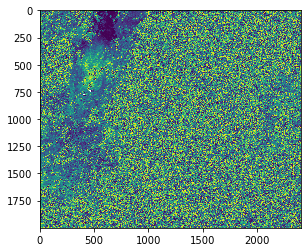

In [9]:
nir_var = rasterio.open("./data/s2/B08_composite.tif").read(2, masked=True, window=window)
plt.imshow(nir_var)
plt.show()